# Animal Classification Project

In this project we were provided 30 images for 15 different animals. Unlike where we get many images, here not only we get 30 images only, but many of these images are augmented images themselves. This presents a unique problem where we have very low number of images in training while most of the standard CNN architectures need huge amount images to train.

In order to handle this situation we will first adjust VGG architecture by removing a bit of complexity so that our training images could be trained properly. But while it improved in performance compared to the full VGG-19 architecture, validation accuracy was only 78%, which is acceptable for such a small dataset but we could do better with transfer learning.

This project is divided into three parts:
1. Data Preparation
2. VGG Based Model Training and Analysis
3. InceptionV3 Model Training and Analysis
4. Conclustion

## Data Preparation

In this step we will import the required libraries and prepare the dataset for training.

In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

In [2]:
#importing dataset

df_train = tf.keras.utils.image_dataset_from_directory('dataset',
                                                         validation_split = 0.2,
                                                         image_size = (224,224),
                                                         subset = 'training',
                                                         seed = 10,
                                                         batch_size = 32
                                                         )

df_val = tf.keras.utils.image_dataset_from_directory('dataset',
                                                     validation_split = 0.2,
                                                     image_size = (224,224),
                                                     subset = 'validation',
                                                     seed = 10,
                                                     batch_size = 32
                                                    )

Found 1944 files belonging to 15 classes.
Using 1556 files for training.


I0000 00:00:1754409841.055717  162970 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 1944 files belonging to 15 classes.
Using 388 files for validation.


In [3]:
#class names

class_names = df_train.class_names
print(class_names)

['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


2025-08-05 21:34:03.445294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


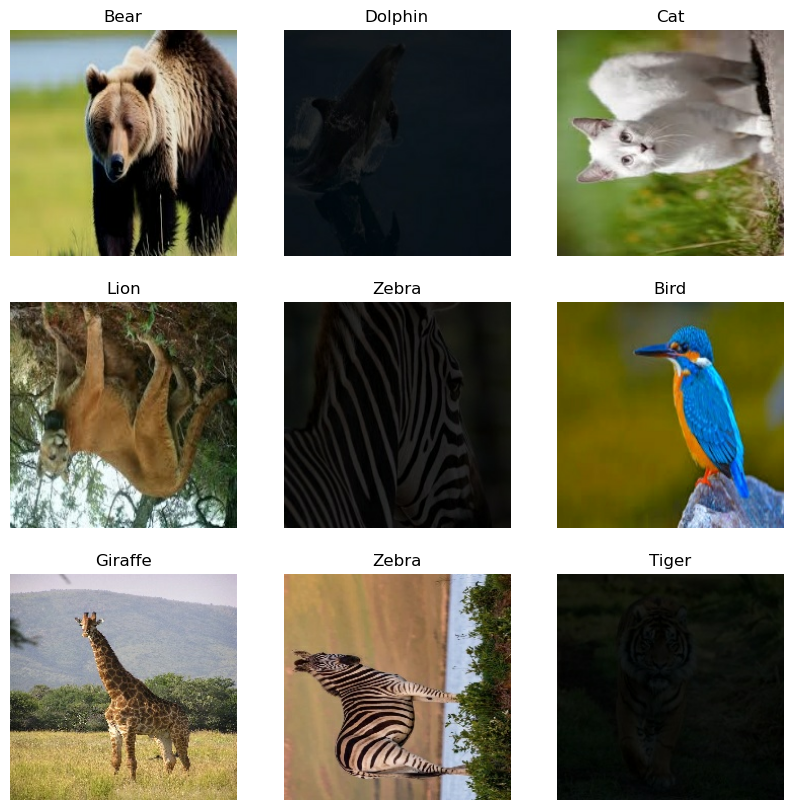

In [4]:
#observing some images

plt.figure(figsize = (10,10))
for images, labels in df_train.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype(int))
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.show()

The above images clearly shows the problem we have with this dataset, it has only few original images with most of the images being generated out of data augmentation client did. This gives us less than 10 or so original images and we can't even apply our own data augmentation or images will shift to such a level that model will not be able to learn the features properly. 

To combat this we will use slighlty adjusted VGG Architecture. We will reduce the number of filters for some layers and reduce the number of dense units in first interconnected layers, regardless model will be based on the VGG architecture where we stack filters to increase the receptive fields and increasing the filters or channels as we go deeper while applying maxpooling as we go. And we will also use batchnorm and dropout for the fully connected layers. 

In [71]:
df_train = df_train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
df_val = df_val.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## VGG Based Model Training and Analysis

In [7]:
#VGG Based Model

model_vgg = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (224,224,3), name = 'input'),
    tf.keras.layers.Rescaling(1./255),
 
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),
    
    tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1024, use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(512, use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(15, activation = 'softmax', name = 'prediction'),
])

In [8]:
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,359,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,607,759 (25.21 MB)

 Trainable params: 6,602,639 (25.19 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [10]:
#We will use 2 callbacks here, one for earlystopping and other for learning rate which will reduce LR is model is stuck on a saddle point

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, factor = 0.5)

In [11]:
model_vgg.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = tf.keras.optimizers.RMSprop(0.001),
    metrics = ['accuracy']
)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
model_history = model_vgg.fit(df_train, epochs = 100, callbacks = [early_stop, reduce_lr], validation_data = df_val)

Epoch 1/100


I0000 00:00:1754409848.193523  163124 service.cc:152] XLA service 0x77dd380038c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754409848.193584  163124 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-05 21:34:08.270765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754409848.721780  163124 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1754409860.090830  163124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0847 - loss: 3.1969

2025-08-05 21:34:35.561245: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222_0', 412 bytes spill stores, 1028 bytes spill loads

2025-08-05 21:34:35.795115: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 172 bytes spill stores, 460 bytes spill loads

2025-08-05 21:34:36.100852: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 992 bytes spill stores, 996 bytes spill loads

2025-08-05 21:34:36.143119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 3912 bytes spill stores, 3900 bytes spill loads

2025-08-05 21:34:36.335188: I e

49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 490ms/step - accuracy: 0.0850 - loss: 3.1946 - val_accuracy: 0.0619 - val_loss: 7.1706 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.1351 - loss: 2.7829 - val_accuracy: 0.0928 - val_loss: 5.0133 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.1563 - loss: 2.6703 - val_accuracy: 0.1134 - val_loss: 3.0863 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.1947 - loss: 2.5276 - val_accuracy: 0.1546 - val_loss: 2.7426 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.1996 - loss: 2.5075 - val_accuracy: 0.1443 - val_loss: 3.9737 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.2323 - loss: 2.3741 - val_accuracy: 0.2062 - val_loss: 2.5841 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.2542 - loss: 2.2572 - val_

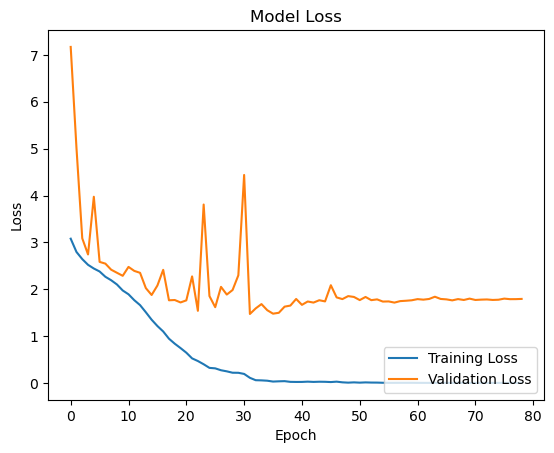

In [43]:
#Plotting the model loss 

plt.plot(model_history.history['loss'], label = 'Training Loss')
plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Model loss has been steadily going down with variability in validation loss till 30 epochs where model was not able to improve in training loss which already reached a near 0 at that point, this stabilized the Validation loss. 

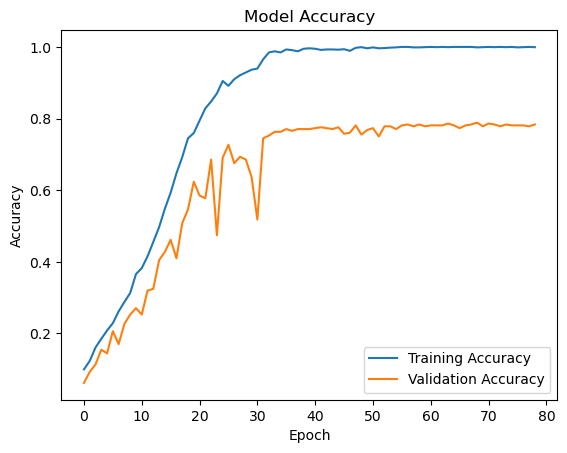

In [41]:
#Plotting Model Accuracy

plt.plot(model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Just like loss plot accuracy is stabilizing for both training and validation after 30 epochs. There does not appears to be any overfitting in model training, however we could have gotten better results with better dataset as complex CNN architectures need large amount of data to learn representations in deep models.

Nevertheless, with our custom CNN model we got highest Validation Accuracy of 0.7887 which is not a bad result considering the limited dataset but this performance is again validation dataset which contain similar data augmentation based images which are not representative of real use of such classifier, we will analyze this point further in Conclusion.

## InceptionV3 Model Training And Analysis

In this part we will apply transfer learning by taking a fully trained InceptionV3 model and adding our own Fully Connected layers. Since we have limited data, we will freeze the Inception model layers and only train our Fully Connected layers.

In [14]:
#We will use weights trained on Imagenet

pretrained_inception = tf.keras.applications.inception_v3.InceptionV3(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet'
)

for layer in pretrained_inception.layers:
    layer.trainable = False

In [22]:
pretrained_inception.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_6[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
#As last layer of the model, we will use mixed 8, we could take mixed 7 too

last_layer = pretrained_inception.get_layer('mixed8')
last_output = last_layer.output

In [27]:
#setting up last layers of pretrained model

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(15, activation = 'sigmoid')(x)

model_inception = tf.keras.Model(inputs = pretrained_inception.input, outputs = x)

In [25]:
#Image preprocessing required for the inceptionv3 model

def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

df_train_v3 = (df_train.map(preprocess).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)) 
df_val_v3 = (df_val.map(preprocess).cache().prefetch(tf.data.AUTOTUNE))

In [28]:
model_inception.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
                            loss = 'sparse_categorical_crossentropy',
                            metrics = ['accuracy'])

In [31]:
model_inc_history = model_inception.fit(df_train_v3, validation_data = df_val_v3, epochs = 50, callbacks = [early_stop, reduce_lr])

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3782 - loss: 2.0466 

2025-08-05 21:54:50.291802: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1966_0', 460 bytes spill stores, 1020 bytes spill loads

2025-08-05 21:54:50.446608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1966', 832 bytes spill stores, 832 bytes spill loads

2025-08-05 21:54:50.448171: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1966', 488 bytes spill stores, 488 bytes spill loads

2025-08-05 21:54:50.475255: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1966', 80 bytes spill stores, 144 bytes spill loads

2025-08-05 21:54:50.912258: I 

49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.3824 - loss: 2.0334 - val_accuracy: 0.8866 - val_loss: 0.4069 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8810 - loss: 0.3937 - val_accuracy: 0.8789 - val_loss: 0.4008 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9653 - loss: 0.1355 - val_accuracy: 0.9227 - val_loss: 0.2165 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9855 - loss: 0.0470 - val_accuracy: 0.9330 - val_loss: 0.2077 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9969 - loss: 0.0249 - val_accuracy: 0.9433 - val_loss: 0.2391 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9984 - loss: 0.0112 - val_accuracy: 0.9046 - val_loss: 0.3933 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9976 - loss: 0

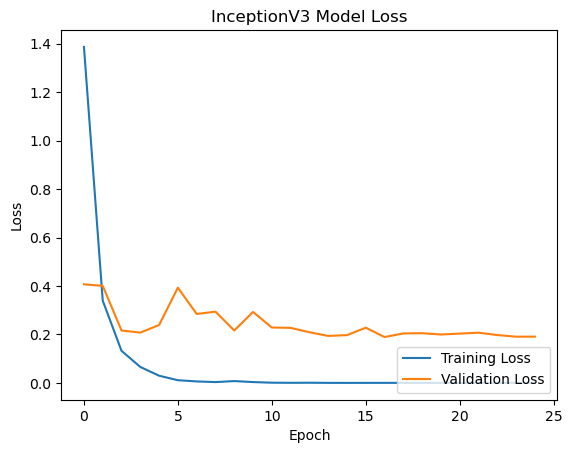

In [46]:
#InceptionV3 model loss plot

plt.plot(model_inc_history.history['loss'], label = 'Training Loss')
plt.plot(model_inc_history.history['val_loss'], label = 'Validation Loss')
plt.title('InceptionV3 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Training Loss had a sharp dive near 5th epoch after which it reached near 0. Even with this small dataset and a very deep model we don't have overfitting for our model, this is the main benefit of transfer learning and is recommended for small datasets.

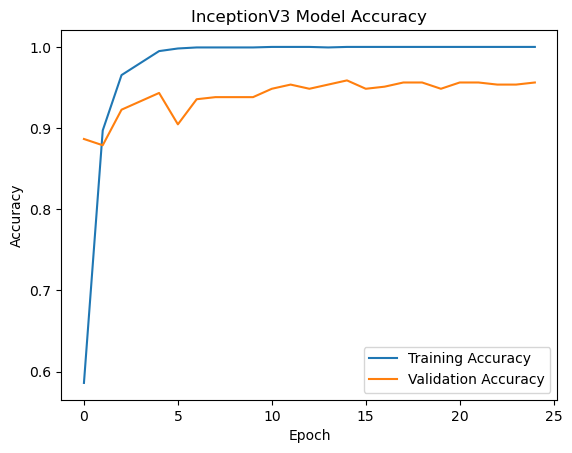

In [45]:
#InceptionV3 model accuracy plot

plt.plot(model_inc_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(model_inc_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('InceptionV3 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Training Accuract reached near 100% at 5th epoch and further epochs only stabilized the validation accuracy which reached one of its highest peak at 95.62%. Maybe we could get marginally better result if we train better but this accuracy is still much better than VGG model.

It takes us fraction of time to train this model compared to VGG Model with much better result. But remember that validation dataset itself is composed of augmented images which does not reflect the real world use of such classifier.

## Conclusion

While we were getting decent result in validation accuracy in models, dataset itself was flawed and may not represent real world images of the animals so we will test few randomly obtained images from internet and compare the result.

In [48]:
#Saving the models
model_vgg.save('model_vgg.keras')
model_inception.save('model_inception.keras')

In [68]:
#Predicting classes in VGG based model

image_paths = ['bear1.jpg', 'bird1.jpg', 'giraffe1.webp', 'kanga1.jpg', 'tiger1.jpg']

for img_path in image_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0 

    prediction = model_vgg.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    print(f"{img_path}: Predicted class {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
bear1.jpg: Predicted class Dolphin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
bird1.jpg: Predicted class Dolphin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
giraffe1.webp: Predicted class Dolphin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
kanga1.jpg: Predicted class Dolphin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
tiger1.jpg: Predicted class Dolphin


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


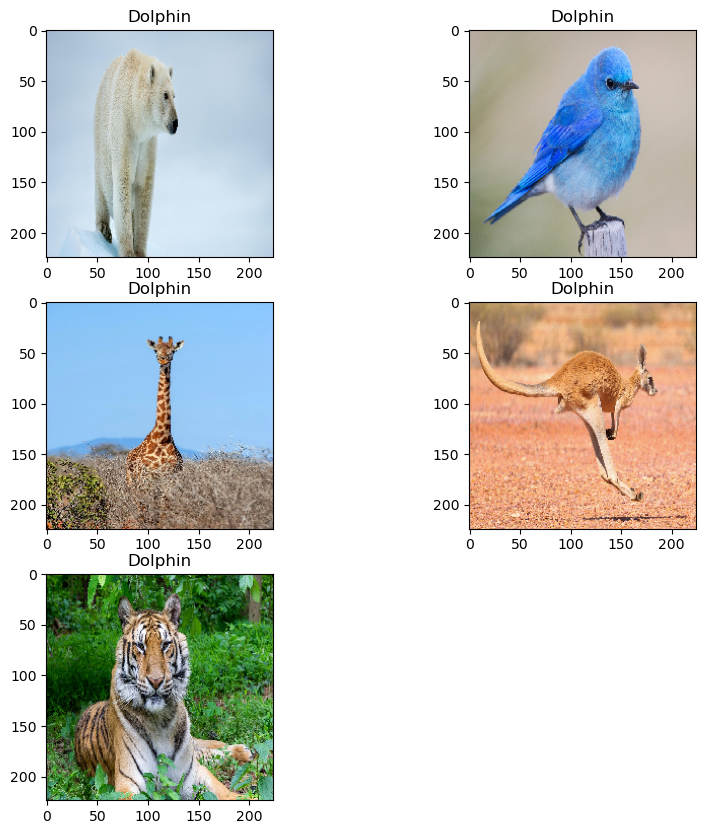

In [81]:
#Visualizing Images

plt.figure(figsize = (10,10))

for i in range(5):
    ax = plt.subplot(3,2, i+1)
    plt.imshow(image.load_img(image_paths[i], target_size=(224, 224)))
    img = image.load_img(image_paths[i], target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0

    prediction = model_vgg.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    plt.title(class_names[predicted_class])

As we can see from the prediction and plots above, as per VGG based model all animals in image are dolphins, this may change as we test more but its a clear representation that this model did not do good work in this task if client's goal is to apply the model in real world scenarios.

In [69]:
#InceptionV3 predictions

for img_path in image_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0

    prediction = model_inception.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    print(f"{img_path}: Predicted class {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
bear1.jpg: Predicted class Bear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
bird1.jpg: Predicted class Bird
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
giraffe1.webp: Predicted class Giraffe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
kanga1.jpg: Predicted class Kangaroo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
tiger1.jpg: Predicted class Tiger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


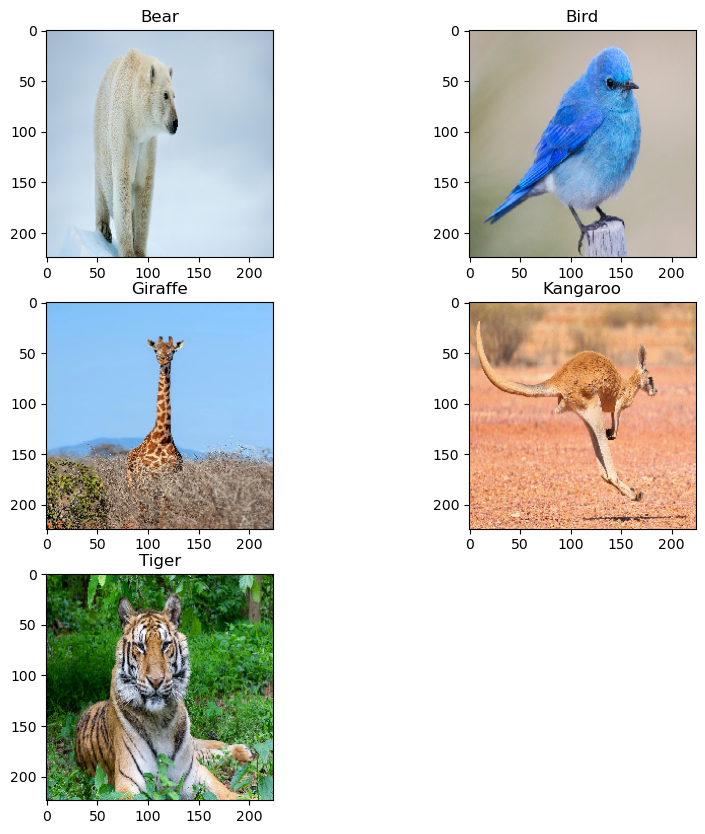

In [80]:
#Visualizing Images

plt.figure(figsize = (10,10))

for i in range(5):
    ax = plt.subplot(3,2, i+1)
    plt.imshow(image.load_img(image_paths[i], target_size=(224, 224)))
    img = image.load_img(image_paths[i], target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0

    prediction = model_inception.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    plt.title(class_names[predicted_class])

InceptionV3 model correctly classifed the images signifying that at least its accuracy of 95% can be relied upon in real world application of this model.

Now we have analyzed both models we can conclude that InceptionV3 model is far better compared to VGG model and any other simpler or complex model we could train on this dataset where we have less than 10 original images for each animal classification. This project while different from other projects where we have thousand of images in training dataset presented its own unique challenges where we don't even have enough training material. Transfer Learning worked very good in this case and we could try different trained CNN architectures and compare the result but InceptionV3 is already among one of the best classification based model with not much difference in it compared to others in terms of performance. 